In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [2]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)
data = pd.read_csv('data_pfas.csv', low_memory=False)
df = data.copy()
df = df[df['pfas_values'] != '[]']

In [3]:
def json_norm(df, column='pfas_values', dataset_id_column='dataset_id'):
   
    # Étape 1 : Appliquer json.loads si nécessaire et exploser les listes 'pfas_values'
    df_exploded = (
        df[[column, dataset_id_column]]  # Inclure 'dataset_id' lors de l'explosion
        .copy()
        .assign(pfas_values=lambda x: x[column].apply(lambda v: json.loads(v) if isinstance(v, str) else v))
        .explode(column)  # Exploser la colonne pour avoir une ligne par substance
    )

    # Étape 2 : Filtrer les lignes valides et normaliser les données JSON
    df_pfas = (
        df_exploded[df_exploded[column].notna()]  # Filtrer les lignes où 'pfas_values' n'est pas NaN
        .assign(pfas_values=lambda x: x[column].apply(lambda v: json.loads(v) if isinstance(v, str) else v))  # Appliquer json.loads si nécessaire
        .pipe(lambda x: pd.json_normalize(x[column]))  # Normaliser les données JSON en colonnes
    )

    # Étape 3 : Conserver l'index original et les valeurs de 'dataset_id'
    df_pfas['index_original'] = df_exploded[df_exploded[column].notna()].index

    # Dupliquer 'dataset_id' pour chaque ligne de 'pfas_values'
    df_pfas['dataset_id'] = df_exploded.loc[df_exploded[column].notna(), dataset_id_column].values

    return df_pfas


In [4]:
df_pfas = json_norm(df, column='pfas_values',  dataset_id_column='dataset_id')

In [5]:
df = df.merge(df_pfas,
              left_index=True, 
              right_on='index_original', 
              how='outer', 
              suffixes=('', '_json')
             )
# Suppression des colonnes doublons (suffixées avec '_json')
for col in df.columns:
    if col.endswith('_json'):
        original_col = col.replace('_json', '')
        # Vérifie que les deux colonnes existent avant de supprimer
        if original_col in df.columns and col in df.columns:
            df.drop(columns=[col], inplace=True)
df.drop(columns=['pfas_values'], inplace=True)

In [6]:
df.head()

,category,lat,lon,name,city,country,type,sector,source_type,source_text,source_url,dataset_id,dataset_name,unit,pfas_sum,details,matrix,date,year,cas_id,substance,value,isomer,less_than,index_original
0,Known,"50,808932","3,352552",Maes,Zwevegem,Belgium,Industrial site,Finishing of textiles,FOI,European Commission Joint Research Center,https://drive.google.com/drive/folders/1CKxJ5Q...,10,15 textile facilities emitting PFAS,ng/l,130,{},Surface water,NaN,2018.0,335-67-1,PFOA,90.0,NaN,NaN,12991
1,Known,"50,808932","3,352552",Maes,Zwevegem,Belgium,Industrial site,Finishing of textiles,FOI,European Commission Joint Research Center,https://drive.google.com/drive/folders/1CKxJ5Q...,10,15 textile facilities emitting PFAS,ng/l,130,{},Surface water,NaN,2018.0,1763-23-1,PFOS,40.0,NaN,NaN,12991
2,Known,"51,016507","4,088303",Tarkett,Dendermonde,Belgium,Industrial site,Finishing of textiles,FOI,European Commission Joint Research Center,https://drive.google.com/drive/folders/1CKxJ5Q...,10,15 textile facilities emitting PFAS,ng/l,200,{},Surface water,NaN,2017.0,335-67-1,PFOA,200.0,NaN,NaN,12992
3,Known,"51,042282","3,548967",Ververijen Escotex,Deinze,Belgium,Industrial site,Finishing of textiles,FOI,European Commission Joint Research Center,https://drive.google.com/drive/folders/1CKxJ5Q...,10,15 textile facilities emitting PFAS,ng/l,42400,{},Surface water,NaN,2016.0,335-67-1,PFOA,41400.0,NaN,NaN,12993
4,Known,"51,042282","3,548967",Ververijen Escotex,Deinze,Belgium,Industrial site,Finishing of textiles,FOI,European Commission Joint Research Center,https://drive.google.com/drive/folders/1CKxJ5Q...,10,15 textile facilities emitting PFAS,ng/l,42400,{},Surface water,NaN,2016.0,1763-23-1,PFOS,500.0,NaN,NaN,12993


In [7]:
df['dataset_id'].value_counts().head()

dataset_id
29    1188235
16     828424
28     456549
54     314637
57     222640
Name: count, dtype: int64

In [8]:
data_29 = df.loc[df['dataset_id'] == 29]
data_29['date'] = pd.to_datetime(data_29['date'], format='%Y-%m-%d')
data_29['cas_id'].value_counts()

C:\Users\User\AppData\Local\Temp\ipykernel_13560\1050876718.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_29['date'] = pd.to_datetime(data_29['date'], format='%Y-%m-%d')


cas_id
1763-23-1      142466
335-67-1       115953
307-24-4       110989
355-46-4       110602
335-76-2       105325
375-85-9        84940
335-77-3        83485
375-95-1        55912
307-55-1        55048
2058-94-8       54494
754-91-6        37847
376-06-7        31539
375-22-4        31141
375-73-5        30463
72629-94-8      30305
375-92-8        29297
2706-90-3       28625
749786-16-1      8871
68259-12-1       8865
2706-91-4        8232
791563-89-8      8230
79780-39-5       8142
27619-97-2       1915
757124-72-4      1850
39108-34-4       1850
53826-12-3       1849
Name: count, dtype: int64

In [9]:
data_29.loc[data_29['cas_id'] == '1763-23-1', 'less_than'].value_counts().sort_index(ascending=True).head()

less_than
0.2    2445
0.3       3
0.4       6
0.6     429
0.7       3
Name: count, dtype: int64

In [10]:
PFOS_29 = data_29.loc[(data_29['cas_id'] == '1763-23-1') & ((data_29['less_than'] <= 4) | (data_29['value'].notna())) & (data_29['date'] >= '2014-01-01' )]

In [11]:
PFOS_29_top = PFOS_29[['lat', 'lon']].value_counts()[PFOS_29[['lat', 'lon']].value_counts() >= 100]
PFOS_29_top

lat        lon     
49,347886  0,565379    201
49,310144  1,236656    200
49,287347  1,209558    200
48,312502  7,713469    142
48,681534  7,919778    140
48,700651  4,587425    124
49,436147  2,87647     124
49,11998   1,645123    124
48,944717  3,124601    124
49,915004  1,095207    124
49,441518  2,864521    123
48,745673  4,62582     118
49,48011   4,579073    114
47,956008  3,531826    107
48,988843  2,07202     106
48,816895  2,41963     103
48,38742   2,959478    101
48,988639  2,0829      101
48,388824  2,95968     100
48,936782  2,038835    100
Name: count, dtype: int64

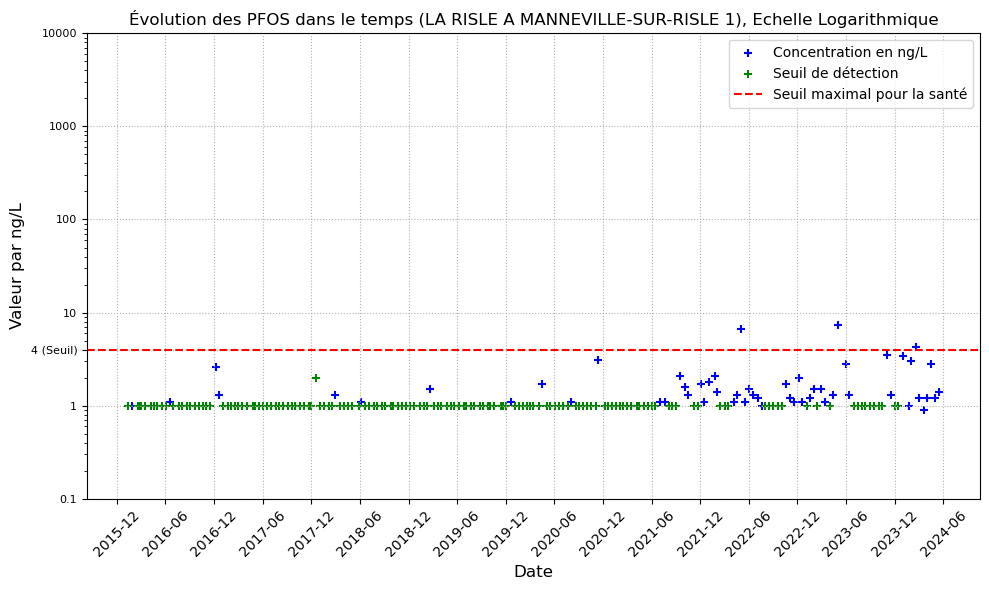

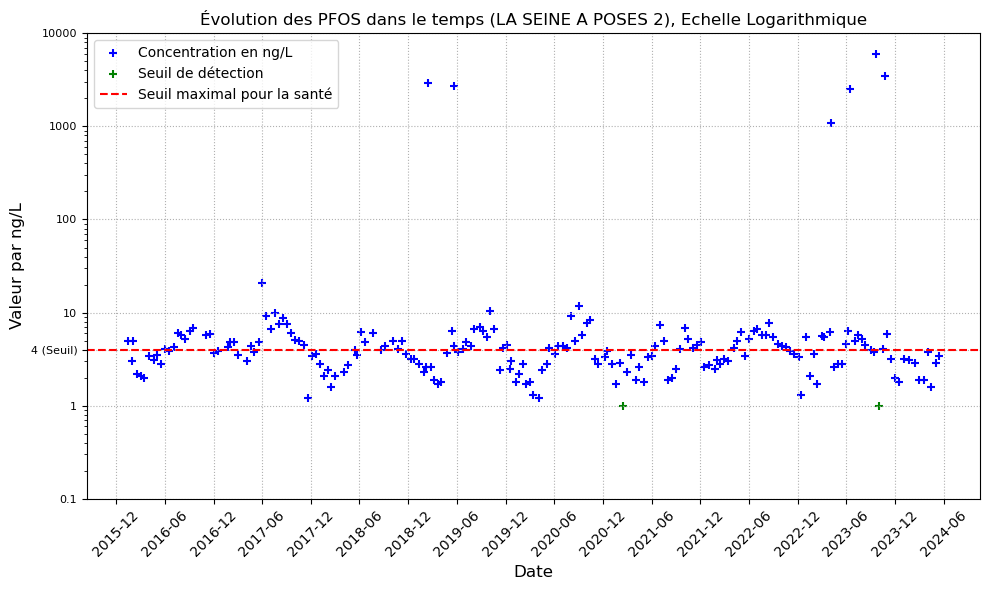

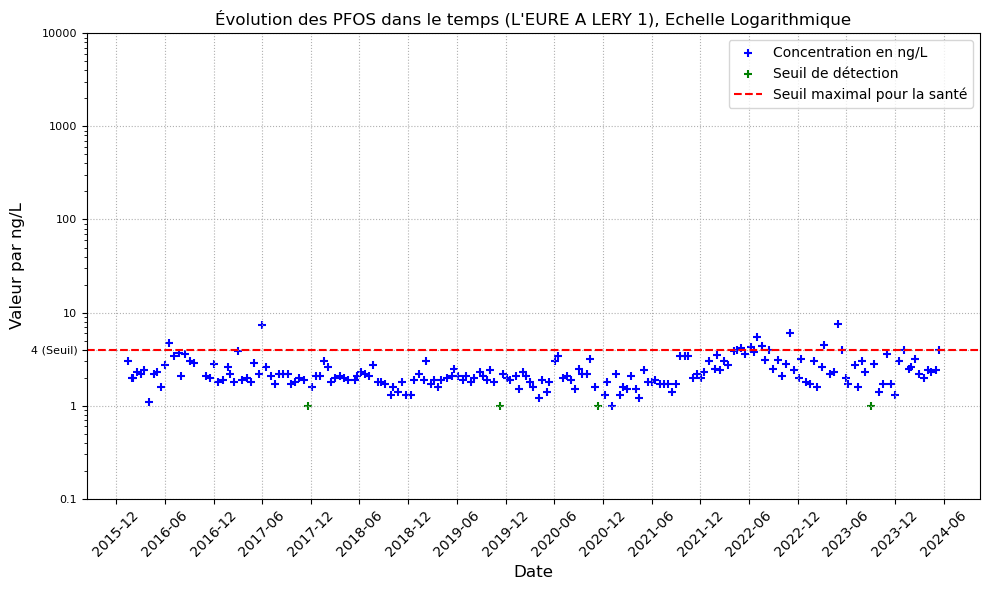

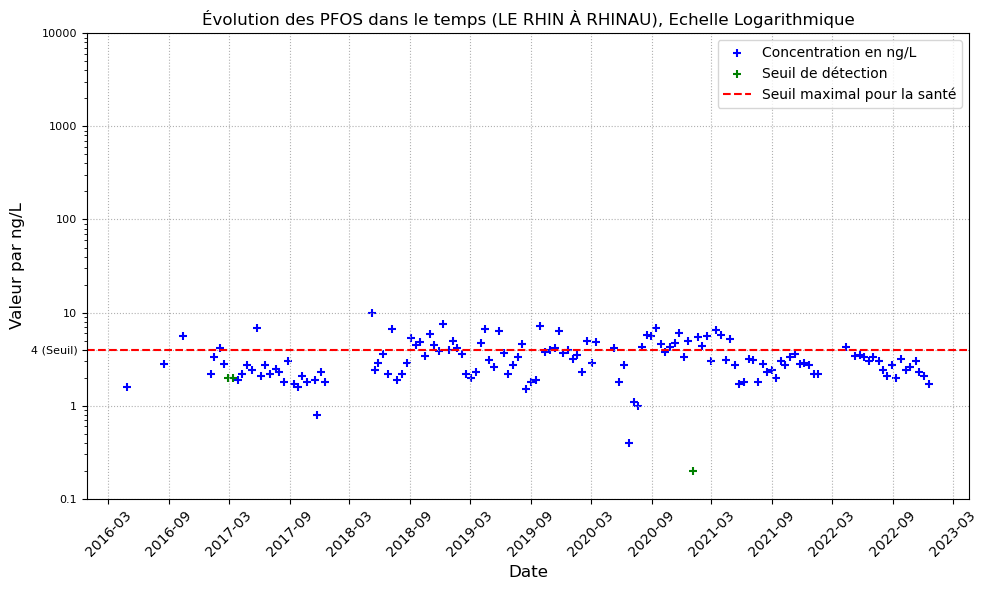

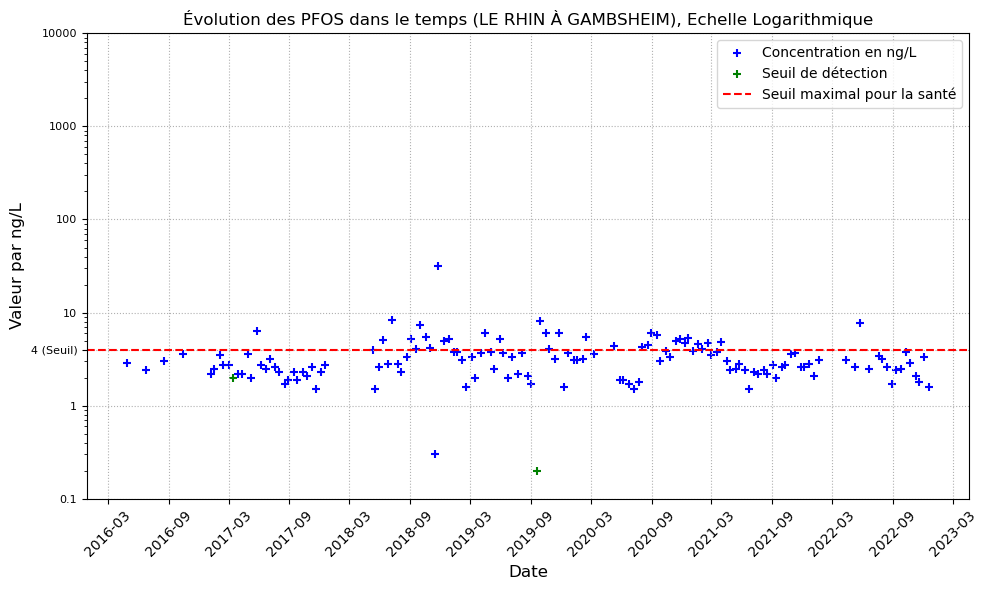

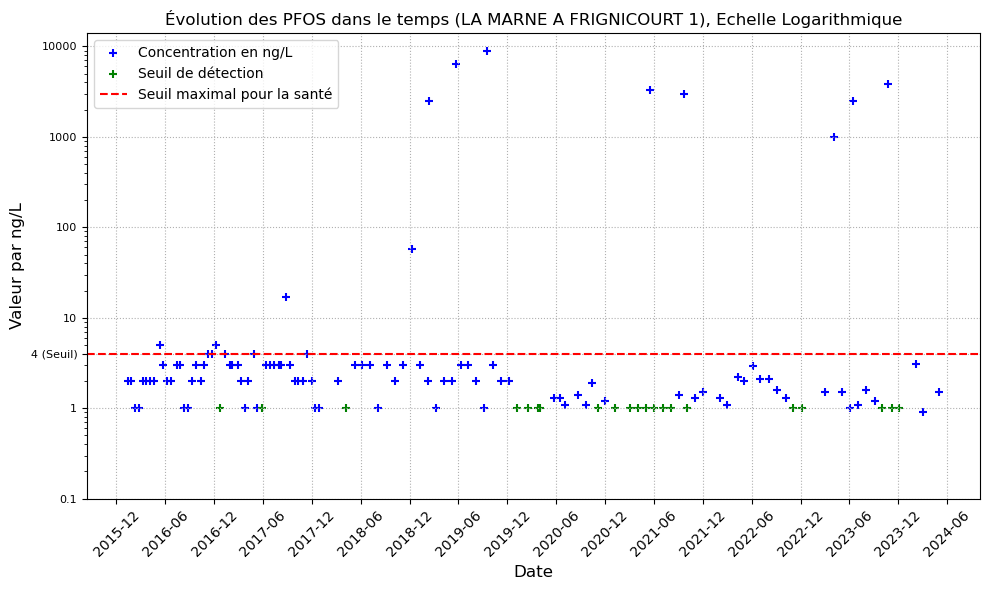

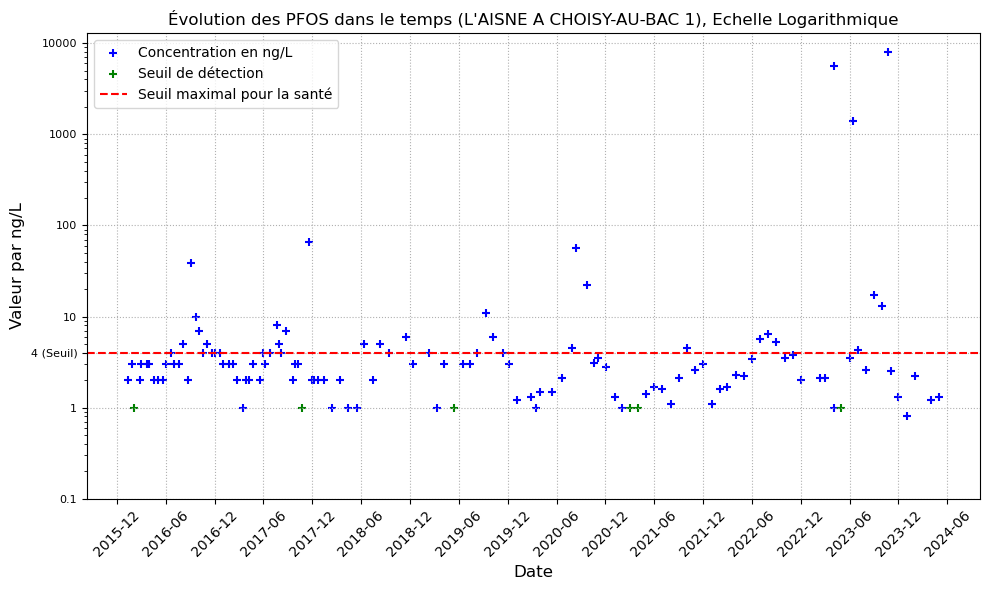

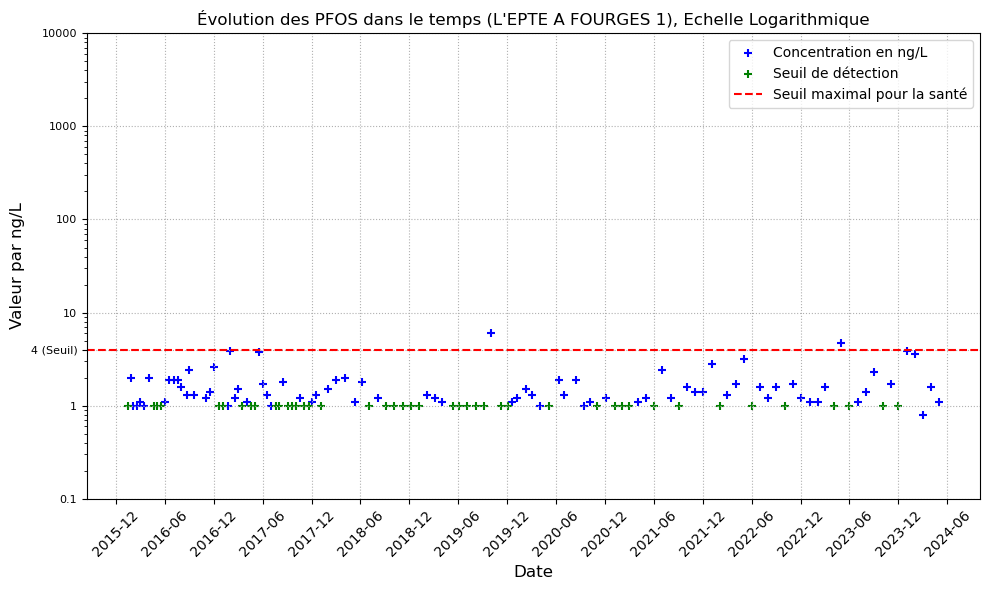

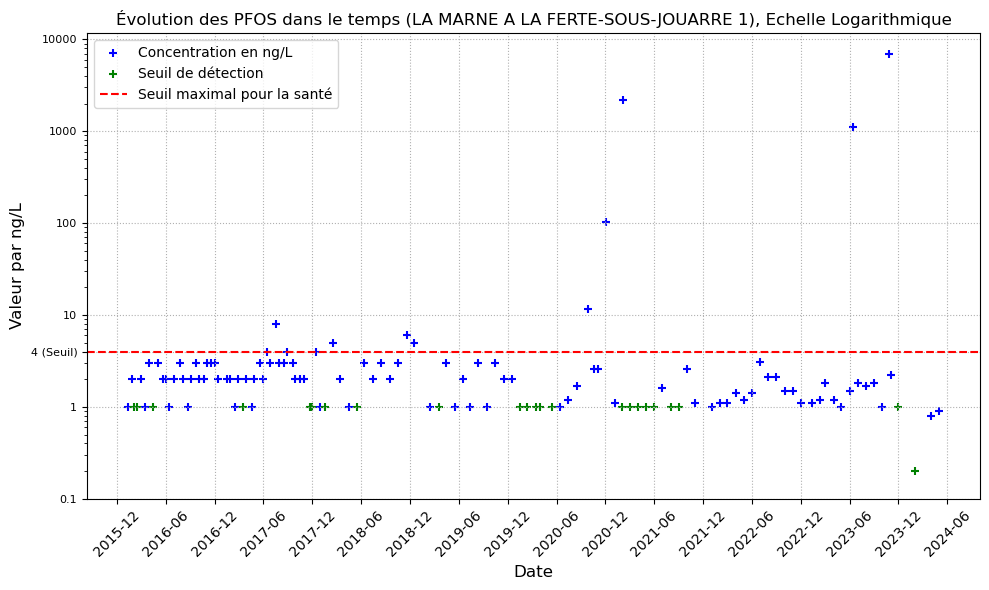

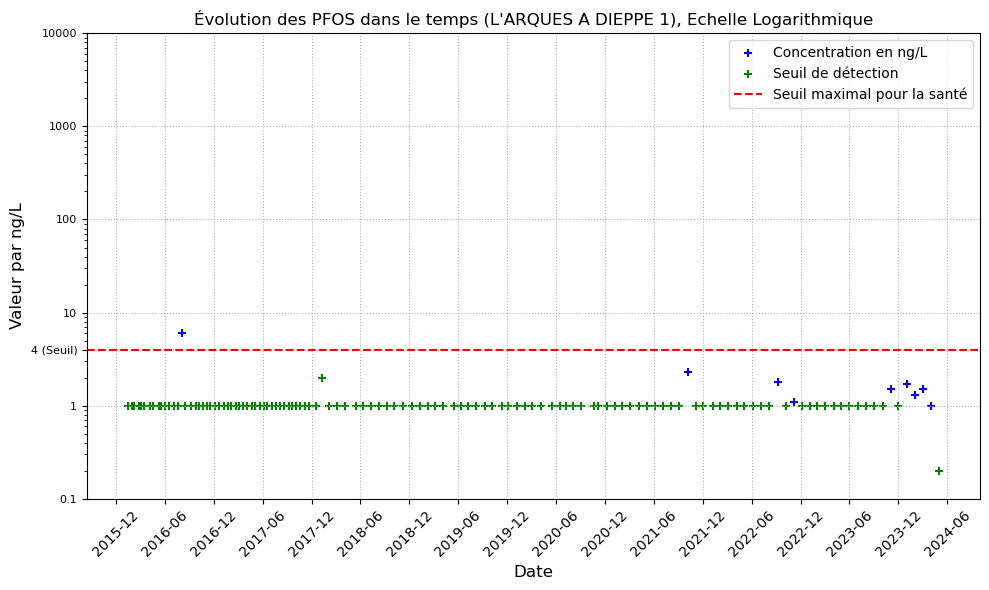

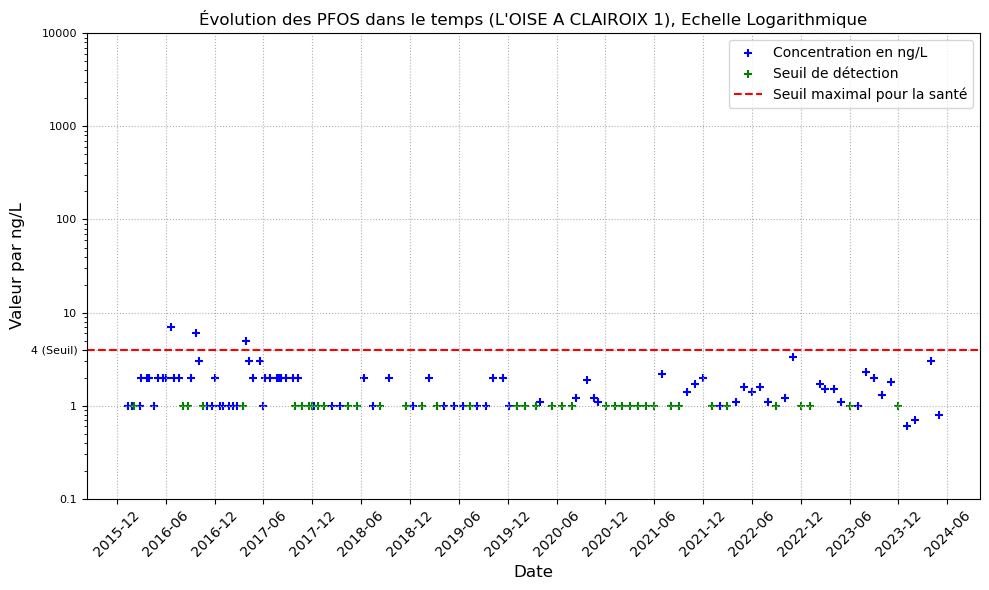

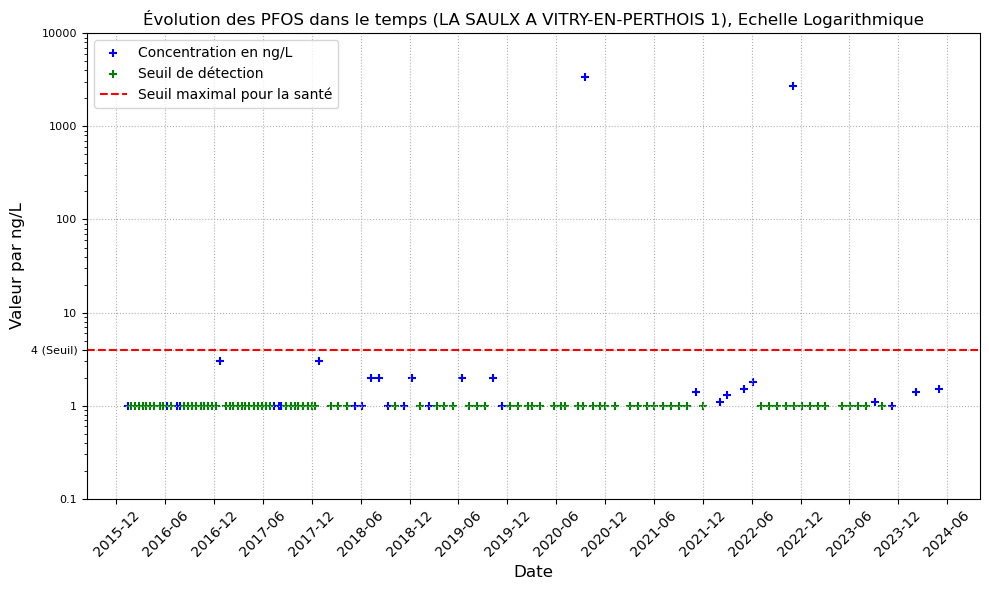

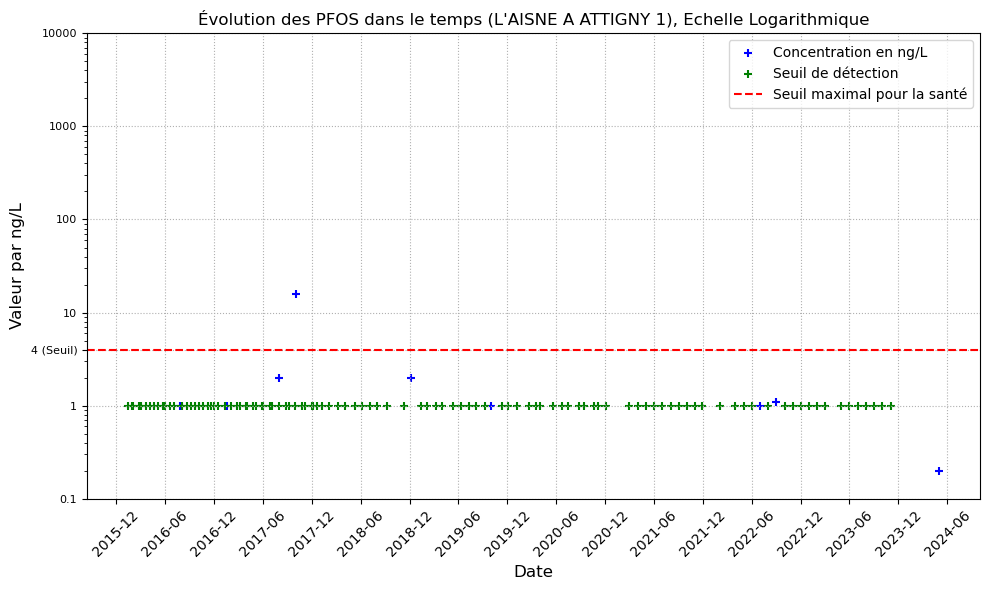

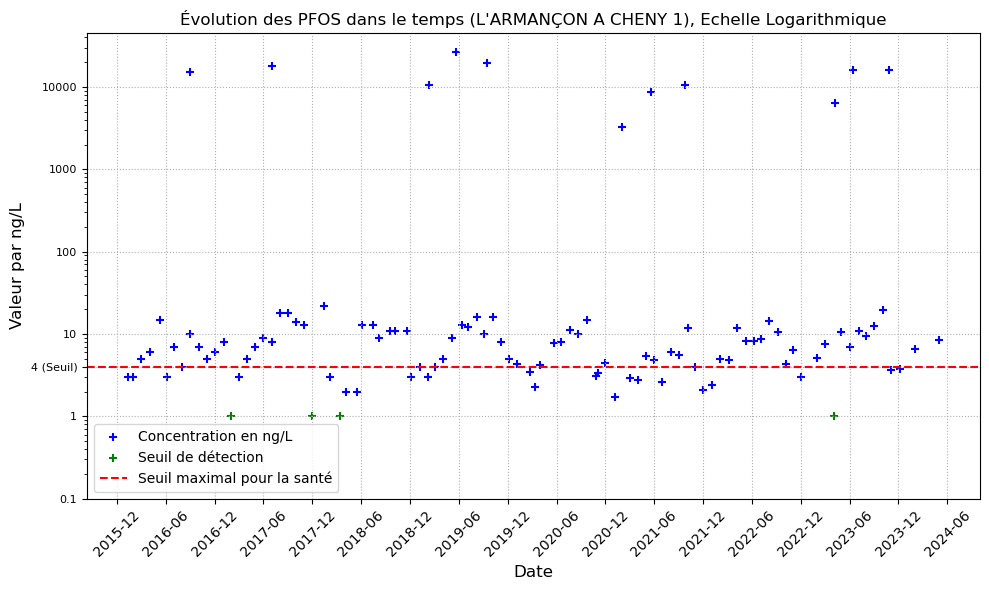

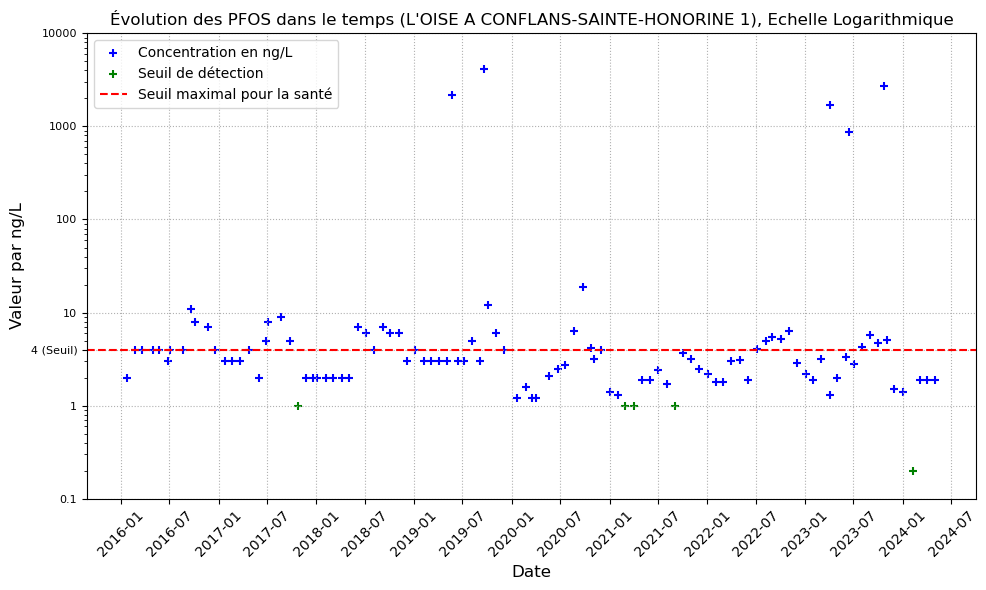

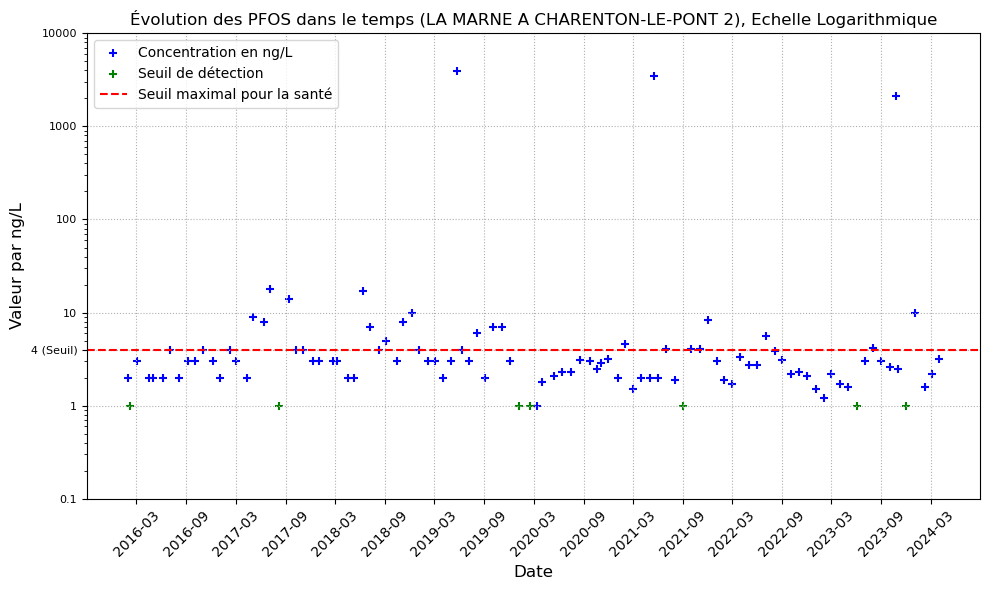

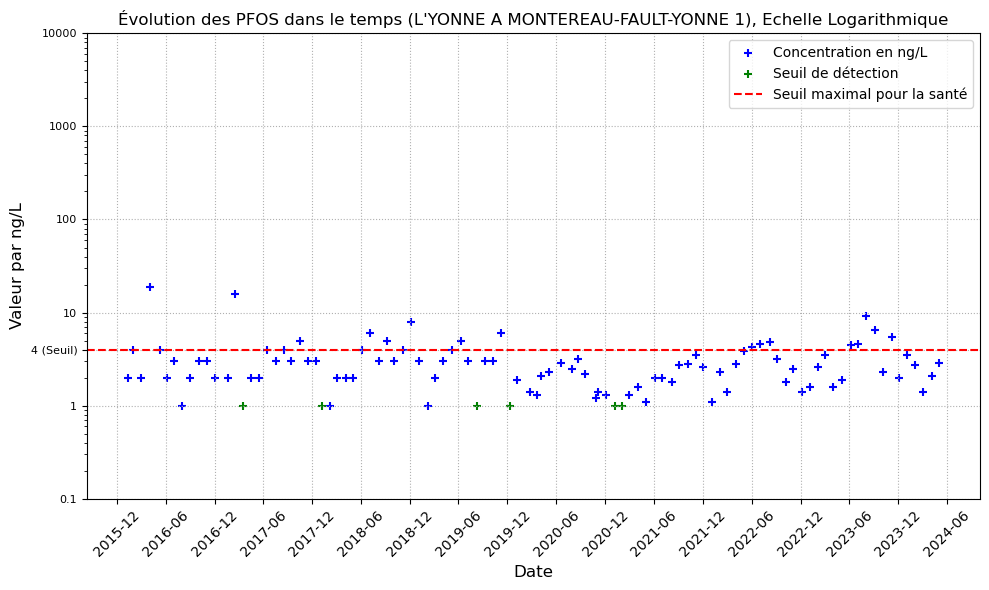

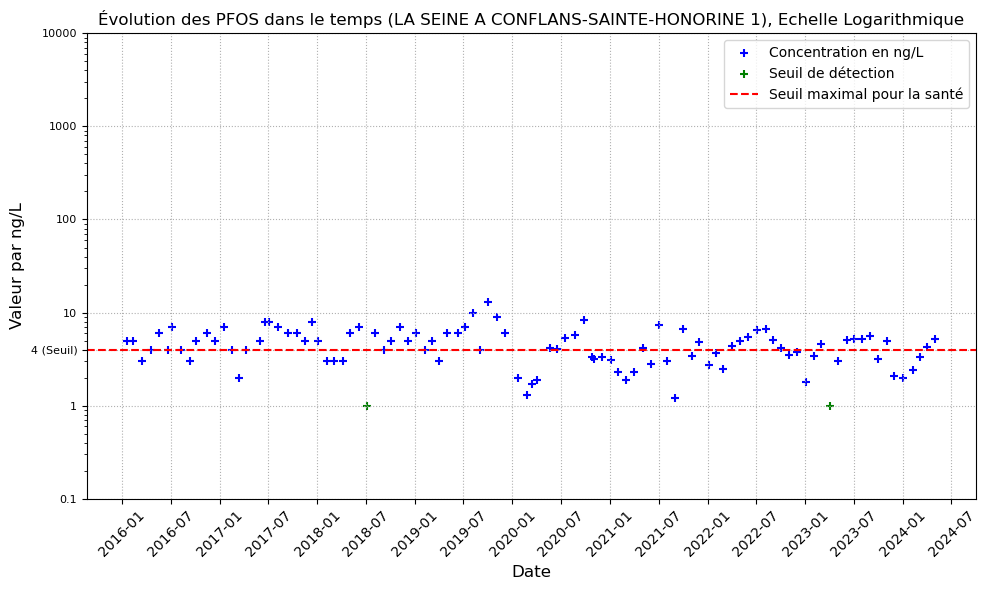

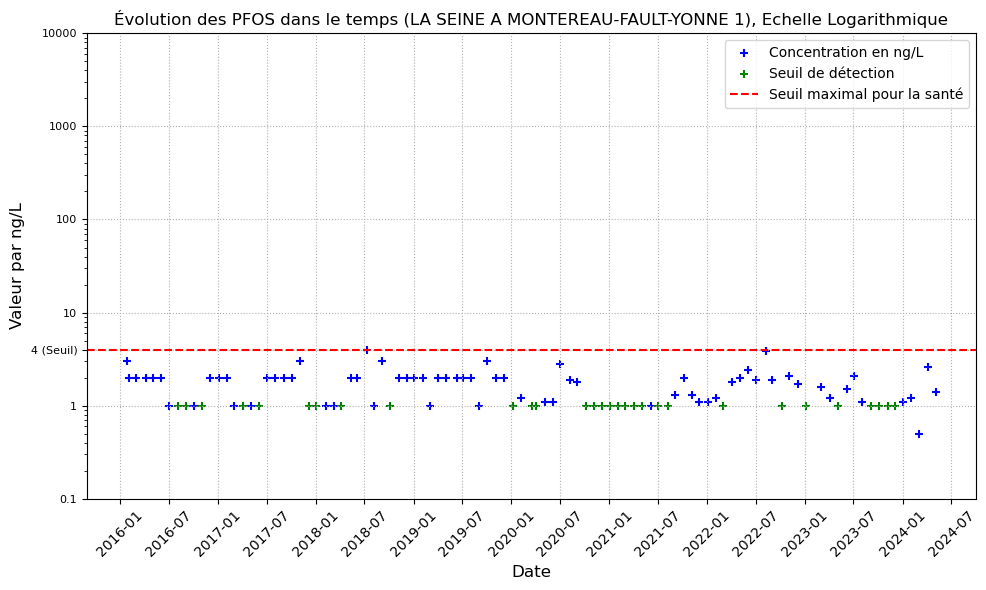

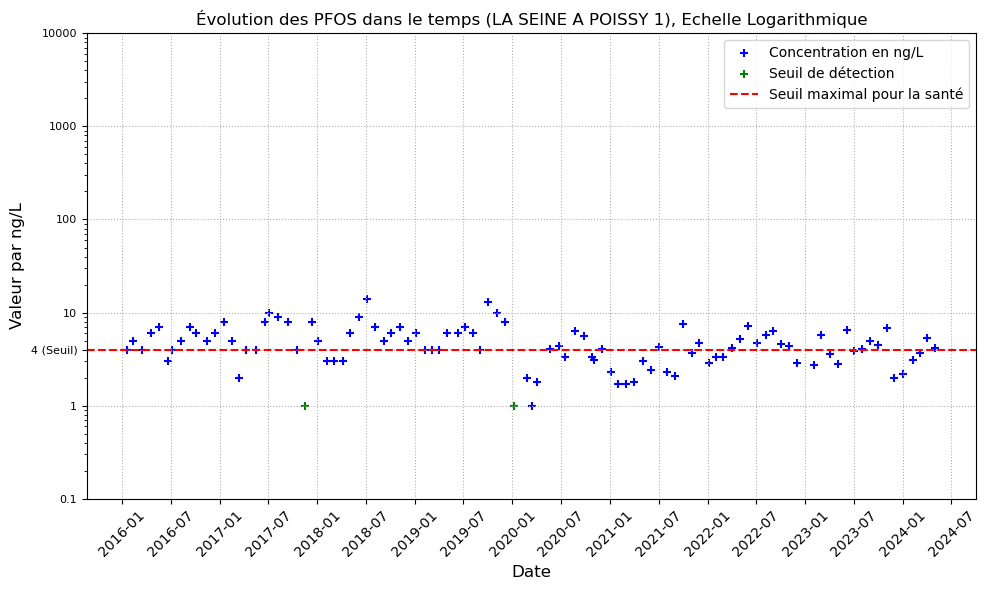

In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import ScalarFormatter

# Boucle sur chaque combinaison de 'lat' et 'lon' dans PFOS_29_top
for (lat, lon), count in PFOS_29_top.items():
    # Filtrer les données pour la combinaison spécifique de 'lat' et 'lon'
    filtered_data = PFOS_29[(PFOS_29['lat'] == lat) & (PFOS_29['lon'] == lon)]
    
    # Si aucune donnée n'est trouvée pour la combinaison actuelle, passer à la suivante
    if filtered_data.empty:
        print(f"Pas de données pour la combinaison lat: {lat}, lon: {lon}")
        continue

    # Obtenir le nom du site ou, si la colonne 'name' n'existe pas, utiliser les coordonnées
    site_name = filtered_data['name'].iloc[0] if 'name' in filtered_data.columns else f"lat: {lat}, lon: {lon}"

    # Créer une nouvelle figure pour chaque combinaison de 'lat' et 'lon'
    plt.figure(figsize=(10, 6))

    # Tracer les points pour les valeurs non-nulles de la concentration
    if 'value' in filtered_data.columns:
        plt.scatter(filtered_data['date'][filtered_data['value'].notna()],
                    filtered_data['value'][filtered_data['value'].notna()],
                    marker='+', c='b', label='Concentration en ng/L')

    # Tracer les points pour les valeurs du seuil de détection
    if 'less_than' in filtered_data.columns:
        plt.scatter(filtered_data['date'][filtered_data['less_than'].notna()],
                    filtered_data['less_than'][filtered_data['less_than'].notna()],
                    marker='+', c='g', label='Seuil de détection')

    # Ajouter une ligne rouge horizontale pour indiquer le seuil maximal pour la santé
    plt.axhline(y=4, color='red', linestyle='--', label='Seuil maximal pour la santé')

    # Ajouter des titres et des labels aux axes
    plt.title(f'Évolution des PFOS dans le temps ({site_name}), Echelle Logarithmique', fontsize=12)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Valeur par ng/L', fontsize=12)
    plt.legend()

    # Ajuster l'échelle de l'axe Y en échelle logarithmique pour mieux visualiser les variations
    plt.yscale('log')

    # Formater les étiquettes de l'axe Y pour éviter la notation scientifique
    plt.gca().yaxis.set_major_formatter(ScalarFormatter())
    plt.gca().ticklabel_format(style='plain', axis='y', useOffset=False)

    # Définir manuellement les étiquettes principales de l'axe Y pour plus de clarté
    y_ticks = [0.1, 1, 4, 10, 100, 1000, 10000]
    y_labels = ['0.1', '1', '4 (Seuil)', '10', '100', '1000', '10000']
    
    plt.gca().set_yticks(y_ticks)
    plt.gca().set_yticklabels(y_labels)

    # Réduire la taille de police des étiquettes de l'axe Y pour éviter le chevauchement
    plt.tick_params(axis='y', labelsize=8)
    
    # Ajuster les étiquettes de l'axe X pour qu'elles apparaissent tous les 6 mois
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    # Faire pivoter les étiquettes de date pour une meilleure lisibilité
    plt.xticks(rotation=45)
    plt.grid(linestyle=':')
    plt.tight_layout()

    # Afficher le graphique
    plt.show()


In [13]:
import pandas as pd
import folium

# Filtrer les données correctement
# Sélectionne les lignes où 'cas_id' est '1763-23-1', 'less_than' est inférieur ou égal à 4, ou 'value' n'est pas nul,
# et où la date est postérieure ou égale au 1er janvier 2014
PFOS_29 = data_29.loc[(data_29['cas_id'] == '1763-23-1') & ((data_29['less_than'] <= 4) | (data_29['value'].notna())) & (data_29['date'] >= '2024-01-01')]

# Compter les occurrences de chaque combinaison de 'lat' et 'lon' et filtrer celles qui apparaissent au moins 50 fois
# Cela permet d'identifier les sites qui ont une grande quantité de données
PFOS_29_top = PFOS_29[['lat', 'lon']].value_counts()
PFOS_29_top = PFOS_29_top[PFOS_29_top >= 20]

# Convertir les coordonnées en type float et remplacer les virgules par des points
PFOS_29_top.index = [(float(lat.replace(',', '.')), float(lon.replace(',', '.'))) for lat, lon in PFOS_29_top.index]

# Créer une carte centrée sur la France
m = folium.Map(location=[46.603354, 1.888334], zoom_start=6)

# Ajouter les points des sites PFOS
for (lat, lon), count in PFOS_29_top.items():
    folium.CircleMarker(
        location=[lat, lon],
        radius=5,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.6,
        popup=f"Nombre de prélèvements: {count}"
    ).add_to(m)

# Afficher la carte
m.save('carte_sites_pfos_france.html')
print("Carte enregistrée sous 'carte_sites_pfos_france.html'")


Carte enregistrée sous 'carte_sites_pfos_france.html'
